In [1]:
%load_ext autoreload
%autoreload 2

# Notebook: Models

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbn

sbn.set()

## Load the dataset

In [3]:
from ceruleo.dataset.catalog.CMAPSS import CMAPSSDataset

2022-08-11 12:21:57.614798: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/luciano/venvs/ceruleo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_dataset = CMAPSSDataset(train=True, models='FD001')

test_dataset = CMAPSSDataset(train=False, models='FD001')[15:30]

### Create a transformer for a dataset

In [5]:
from ceruleo.dataset.analysis.numerical_features import analysis
from ceruleo.transformation.functional.transformers import Transformer
from ceruleo.transformation.features.selection import ByNameFeatureSelector, ByTypeFeatureSelector
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.transformation.functional.pipeline.pipeline import make_pipeline
from ceruleo.transformation.features.resamplers import IndexMeanResampler
from ceruleo.transformation.features.transformation import Clip
from ceruleo.transformation.features.slicing import SliceRows
from ceruleo.iterators.iterators import RelativeToEnd
from ceruleo.transformation.features.scalers import MinMaxScaler
from ceruleo.dataset.catalog.CMAPSS import sensor_indices
FEATURES = [train_dataset[0].columns[i] for i in sensor_indices]


In [6]:

transformer = Transformer(
    pipelineX=make_pipeline(
        ByNameFeatureSelector(features=FEATURES), 
        MinMaxScaler(range=(-1, 1))

    ), 
    pipelineY=make_pipeline(
        ByNameFeatureSelector(features=['RUL']),  
    )
)



## Split train-test-validation

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_dataset, val_dataset = train_test_split(train_dataset, train_size=0.9)

In [9]:
len(train_dataset), len(val_dataset), len(test_dataset)

(90, 10, 15)

# Models

## Scikit-learn

In [10]:
import sklearn.pipeline as sk_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from ceruleo.models.sklearn import EstimatorWrapper, TimeSeriesWindowTransformer, CeruleoRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

In [11]:

regressor = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=32,
        padding=True,
        step=1),   
    Ridge(alpha=15))

regressor.fit(train_dataset)

CeruleoRegressor(regressor=Ridge(alpha=15),
                 ts_window_transformer=TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fc96e6b2410>,
                                                                   window_size=32))

### Val dataset results

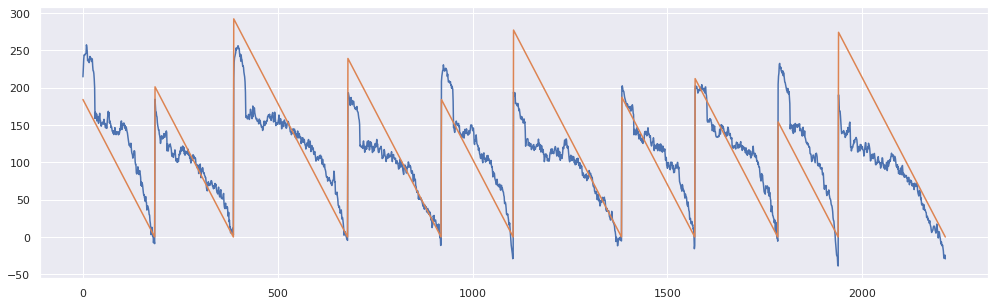

In [12]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(val_dataset))
ax.plot(regressor.ts_window_transformer.true_values(val_dataset))

### Test dataset results

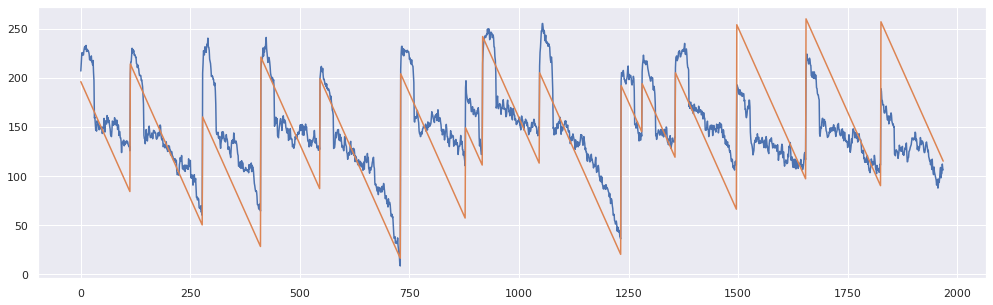

In [13]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.predict(test_dataset))
ax.plot(regressor.ts_window_transformer.true_values(test_dataset))

## Parameters grid search


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from ceruleo.models.sklearn import CeruleoMetricWrapper

regressor_gs = CeruleoRegressor(
    TimeSeriesWindowTransformer(
        transformer,
        window_size=32,
        padding=True,
        step=1),   
    Ridge(alpha=15))

grid_search = GridSearchCV(
    estimator=regressor_gs,
     param_grid={
        'ts_window_transformer__window_size': [5, 10],         
        'regressor': [Ridge(alpha=15), RandomForestRegressor(max_depth=5)]
    },
    scoring=CeruleoMetricWrapper('neg_mean_absolute_error')
)


grid_search.fit(train_dataset)

GridSearchCV(estimator=CeruleoRegressor(regressor=Ridge(alpha=15),
                                        ts_window_transformer=TimeSeriesWindowTransformer(transformer=<ceruleo.transformation.functional.transformers.Transformer object at 0x7fc96e6b2410>,
                                                                                          window_size=32)),
             param_grid={'regressor': [Ridge(alpha=15),
                                       RandomForestRegressor(max_depth=5)],
                         'ts_window_transformer__window_size': [5, 10]},
             scoring=<ceruleo.models.sklearn.CeruleoMetricWrapper object at 0x7fc96cb80f40>)

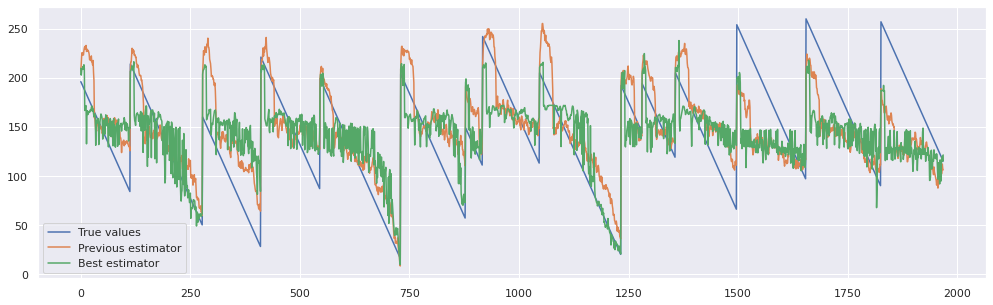

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(regressor.ts_window_transformer.true_values(test_dataset), label='True values')
ax.plot(regressor.predict(test_dataset), label='Previous estimator')

ax.plot(grid_search.best_estimator_.predict(test_dataset), label='Best estimator')
ax.legend()


## Tensorflow // Keras

### Build tf.Data iterators

In [16]:
from ceruleo.iterators.utils import true_values
from ceruleo.iterators.shufflers import AllShuffled
from ceruleo.iterators.iterators import WindowedDatasetIterator
from ceruleo.models.keras.dataset import tf_regression_dataset
import tensorflow as tf

#### Fit the transformer

In [17]:
transformer.fit(train_dataset)

#### Build the WindowedDatasetIterator

In [18]:
train_iterator = WindowedDatasetIterator(
    train_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1,
    shuffler=AllShuffled())

val_iterator = WindowedDatasetIterator(
    val_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

test_iterator = WindowedDatasetIterator(
    test_dataset.map(transformer),
    window_size=32,
    step=1,
    horizon=1)

### Build tensorflow model

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv1D, 
                                     SeparableConv1D, 
                                     GlobalMaxPooling1D,
                                     SpatialDropout1D,
                                     LayerNormalization,
                                     Dropout,
                                     Flatten, Dense, Lambda)

input = Input(train_iterator.shape)
x = Conv1D(64, 3, padding='same', activation='relu')(input)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = Conv1D(64, 3, padding='same', activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(input, x)
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              weighted_metrics=[])

2022-08-11 12:27:35.523572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:27:35.546268: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:27:35.546609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 12:27:35.547135: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 14)]          0         
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            2752      
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 64)            12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                             

In [21]:

model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=25)

Epoch 1/25


2022-08-11 12:27:37.441132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


      1/Unknown - 2s 2s/step - loss: 89.2836

2022-08-11 12:27:38.427138: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


489/489 [==============================] - 10s 16ms/step - loss: 62.9228 - val_loss: 44.8090
Epoch 2/25
489/489 [==============================] - 9s 18ms/step - loss: 33.0764 - val_loss: 42.2363
Epoch 3/25
489/489 [==============================] - 7s 14ms/step - loss: 31.0855 - val_loss: 44.0638
Epoch 4/25
489/489 [==============================] - 7s 14ms/step - loss: 29.1266 - val_loss: 44.5671
Epoch 5/25
489/489 [==============================] - 8s 17ms/step - loss: 27.4037 - val_loss: 46.0466
Epoch 6/25
489/489 [==============================] - 7s 15ms/step - loss: 26.6138 - val_loss: 46.5758
Epoch 7/25
489/489 [==============================] - 8s 17ms/step - loss: 26.1630 - val_loss: 45.8693
Epoch 8/25
489/489 [==============================] - 7s 14ms/step - loss: 25.8718 - val_loss: 44.5280
Epoch 9/25
489/489 [==============================] - 7s 14ms/step - loss: 25.5201 - val_loss: 46.1632
Epoch 10/25
489/489 [==============================] - 6s 13ms/step - loss: 25.1867

#### Validation set results

60/60 [==============================] - 1s 10ms/step


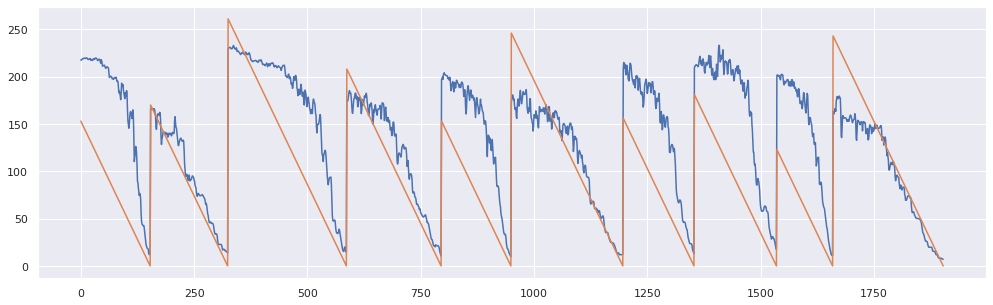

In [22]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(val_iterator).batch(32)))
ax.plot(true_values(val_iterator))

#### Test set results

47/47 [==============================] - 1s 13ms/step


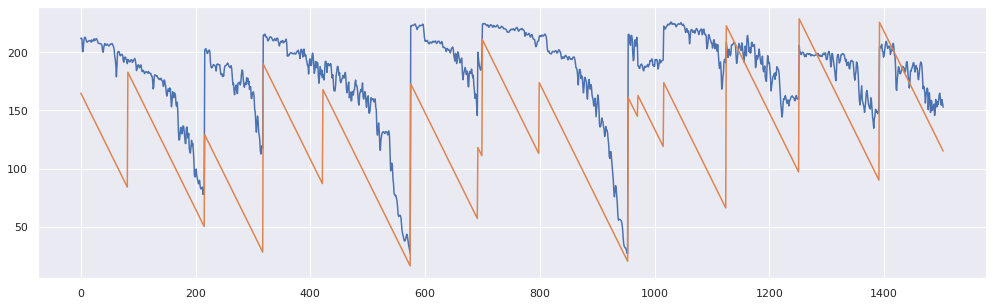

In [23]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(test_iterator).batch(32)))
ax.plot(true_values(test_iterator))

### Model Catalog

Keras model are just functions that return the already created model. There are a few model published in literature ready to use.

In this case we are using the one proposed in 

Temporal Convolutional Memory Networks forRemaining Useful Life Estimation of Industrial Machinery
by Lahiru Jayasinghe, Tharaka Samarasinghe, Chau Yuen, Jenny Chen Ni Low, Shuzhi Sam Ge
    
[Reference](https://ieeexplore.ieee.org/abstract/document/8754956?casa_token=B_YvavFGulsAAAAA:f2k2I8pH1lM3sOcSGlXEF29seYPK1GPa9Od2-TwnhNeFyWvRRUAqkUOdWUNIyy9FPJHhsGM)

In [24]:
from ceruleo.models.keras.catalog.CNLSTM import CNLSTM

model = CNLSTM(
    train_iterator.shape,
    n_conv_layers=3,
    initial_convolutional_size=16,
    layers_recurrent=[32, 32],
    hidden_size=(10, 15),
    dropout=0.3,
)
model.summary()
model.compile(loss='mae', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              weighted_metrics=[])
model.fit(tf_regression_dataset(train_iterator).batch(32),
         validation_data=tf_regression_dataset(val_iterator).batch(32),
         epochs=10)

NameError: name 'CNLSTM' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(val_iterator).batch(32)))
ax.plot(true_values(val_iterator))

In [ ]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(model.predict(tf_regression_dataset(test_iterator).batch(32)))
ax.plot(true_values(test_iterator))

#### Explainable model

## Pytorch